In [20]:
import requests
import time

import warnings
warnings.filterwarnings("ignore")

In [21]:
username = 'OOIAPI-D8S960UXPK4K03'
token = 'IXL48EQ2XY'

In [26]:
subsite = 'RS03AXPS'
node = 'SF03A'
sensor = '3A-FLORTD301'
method = 'streamed'
stream = 'flort_d_data_record'
beginDT = '2014-09-01T01:01:01.000Z'
endDT = '2018-06-30T01:01:01.000Z'

In [27]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}
r = requests.get(data_request_url, params=params, auth=(username, token))
data = r.json()

In [29]:
data['allURLs'][0]

'https://opendap.oceanobservatories.org/thredds/catalog/ooi/ooidatateam@gmail.com/20180619T160407-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record/catalog.html'

In [36]:
%%time
check_complete  = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed
CPU times: user 18 ms, sys: 3.17 ms, total: 21.2 ms
Wall time: 256 ms


In [37]:
import re
import xarray as xr
import pandas as pd
import os

In [38]:
url = data['allURLs'][0]
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180619T160407-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record/deployment0004_RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record_20180501T000001.107685-20180619T160402.351993.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180619T160407-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record/deployment0004_RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record_20180129T000000.744853-20180430T235959.980751.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180619T160407-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record/deployment0004_RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record_20171029T000000.606347-20180128T235959.617928.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180619T160407-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record/deployment0004_

In [41]:
datasets_sel = []
for i in datasets:
    if '2A-CTDPFA302' in i:
        pass
    else:
        datasets_sel.append(i)

In [43]:
datasets_sel

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180619T160407-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record/deployment0004_RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record_20180501T000001.107685-20180619T160402.351993.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180619T160407-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record/deployment0004_RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record_20180129T000000.744853-20180430T235959.980751.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180619T160407-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record/deployment0004_RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record_20171029T000000.606347-20180128T235959.617928.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180619T160407-RS03AXPS-SF03A-3A-FLORTD301-streamed-flort_d_data_record/deployment0004_

In [44]:
# make the output directory
new_dir = 'minute_mean_data/'
if not os.path.isdir(new_dir):
    try:
        os.makedirs(new_dir)
    except OSError:
        if os.path.exists(new_dir):
            pass
        else:
            raise

In [45]:
import pickle as pk
import gc

In [ ]:
num = 0
for i in datasets_sel:
    try:       
        ds = xr.open_dataset(i)
        ds = ds.swap_dims({'obs': 'time'})

        chlor_a_min = pd.DataFrame()
        chlor_a_min['fluorometric_chlorophyll_a'] = ds['fluorometric_chlorophyll_a'].to_pandas().resample('T').mean()
        chlor_a_min['int_ctd_pressure'] = ds['int_ctd_pressure'].to_pandas().resample('T').mean()

        ds['seawater_temperature'].attrs.pop('units')
        chlor_a_min['seawater_temperature'] = ds['seawater_temperature'].to_pandas().resample('T').mean()

        chlor_a_min = chlor_a_min.dropna()

        out = 'minute_mean_data/' + i.split('/')[-1][:-3] + '_resampled' + '.pd'
        num = num +1

        with open(out, 'wb') as fh:
            pk.dump(chlor_a_min,fh)

        gc.collect()
    except:
        pass

In [47]:
import os

In [48]:
# create a single file with all the pickled data.
chlor_a_and_temp = pd.DataFrame()
for path, subdirs, files in os.walk('minute_mean_data/'):
    for name in files:
        file_name = os.path.join(path, name) 
        with open(file_name, 'rb') as f:
            pd_df = pk.load(f)
            chlor_a_and_temp = chlor_a_and_temp.append(pd_df)

with open('chlor_a_and_temp.pd', 'wb') as f:
    pk.dump(chlor_a_and_temp,f)

In [51]:
with open('chlor_a_and_temp.pd', 'rb') as f:
    chlor_a_and_temp_data = pk.load(f)

time_stamp = list(chlor_a_and_temp_data.index.values)
depth = list(chlor_a_and_temp_data['int_ctd_pressure'].values)
flor = list(chlor_a_and_temp_data['fluorometric_chlorophyll_a'].values)
temp = list(chlor_a_and_temp_data['seawater_temperature'].values)

In [55]:
import cmocean
import matplotlib.pyplot as plt
import datetime

(735773.0, 736864.6694444445)

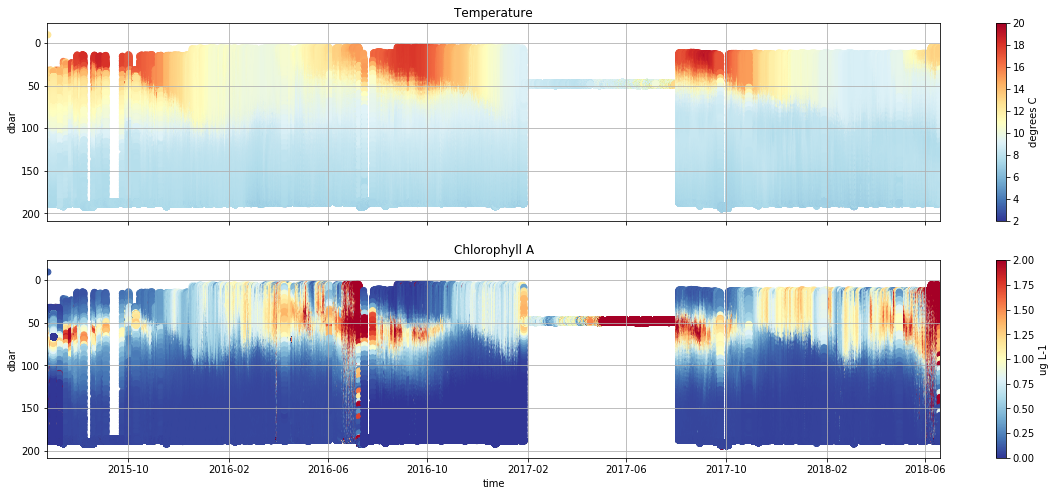

In [61]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
fig.set_size_inches(20, 8)

t = ax1.scatter(time_stamp, depth, c=temp, cmap='RdYlBu_r', vmin=2, vmax=20)
o = ax2.scatter(time_stamp, depth, c=flor, cmap='RdYlBu_r', vmin=0, vmax=2)

cb1 = plt.colorbar(t,ax=ax1)
cb2 = plt.colorbar(o,ax=ax2)

cb1.set_label('degrees C')
cb2.set_label('ug L-1')

ax1.set_ylabel('dbar')
ax2.set_ylabel('dbar')
ax2.set_xlabel('time')

ax1.grid()
ax2.grid()

ax1.set_title("Temperature")
ax2.set_title("Chlorophyll A")

ax1.invert_yaxis()
ax1.set_xlim(min(time_stamp),max(time_stamp))

# xlim_min = datetime.datetime(2015, 12, 1, 0, 0)
# xlim_max = datetime.datetime(2016, 7, 25, 0, 0)
# ax1.set_xlim(xlim_min,xlim_max)
# ax2.set_xlim(xlim_min,xlim_max)

(736116.0, 736238.0)

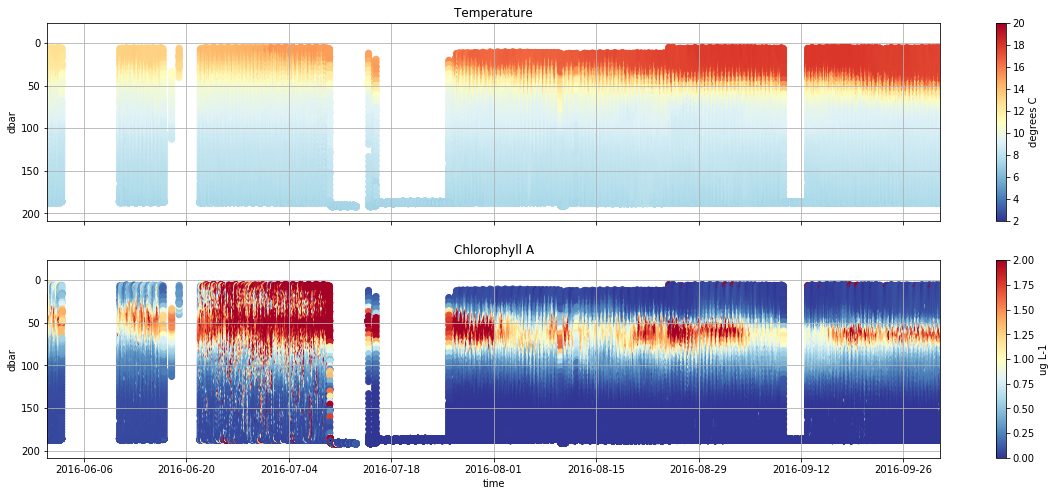

In [62]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
fig.set_size_inches(20, 8)

t = ax1.scatter(time_stamp, depth, c=temp, cmap='RdYlBu_r', vmin=2, vmax=20)
o = ax2.scatter(time_stamp, depth, c=flor, cmap='RdYlBu_r', vmin=0, vmax=2)

cb1 = plt.colorbar(t,ax=ax1)
cb2 = plt.colorbar(o,ax=ax2)

cb1.set_label('degrees C')
cb2.set_label('ug L-1')

ax1.set_ylabel('dbar')
ax2.set_ylabel('dbar')
ax2.set_xlabel('time')

ax1.grid()
ax2.grid()

ax1.set_title("Temperature")
ax2.set_title("Chlorophyll A")

ax1.invert_yaxis()
ax1.set_xlim(min(time_stamp),max(time_stamp))

xlim_min = datetime.datetime(2016, 6, 1, 0, 0)
xlim_max = datetime.datetime(2016, 10, 1, 0, 0)
ax1.set_xlim(xlim_min,xlim_max)
ax2.set_xlim(xlim_min,xlim_max)

(736137.0, 736153.0)

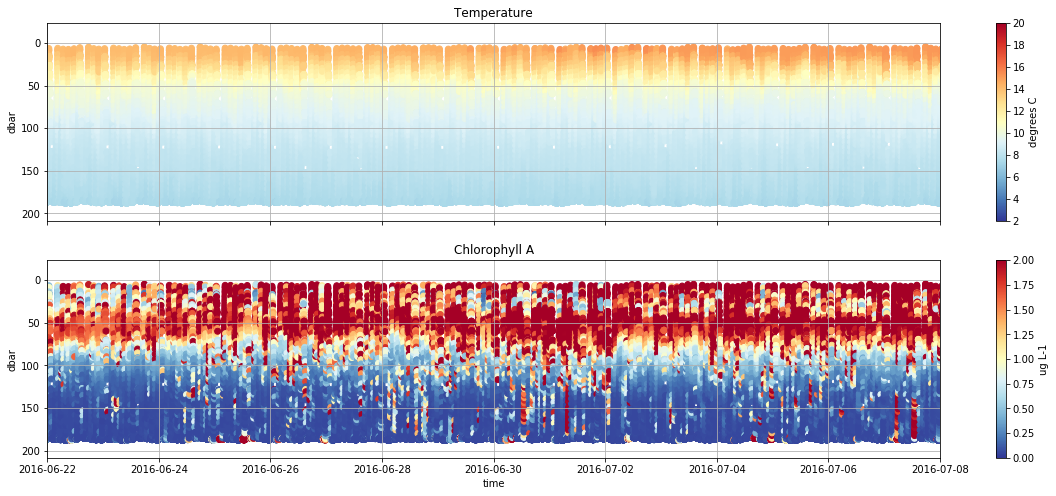

In [64]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
fig.set_size_inches(20, 8)

t = ax1.scatter(time_stamp, depth, c=temp, cmap='RdYlBu_r', vmin=2, vmax=20)
o = ax2.scatter(time_stamp, depth, c=flor, cmap='RdYlBu_r', vmin=0, vmax=2)

cb1 = plt.colorbar(t,ax=ax1)
cb2 = plt.colorbar(o,ax=ax2)

cb1.set_label('degrees C')
cb2.set_label('ug L-1')

ax1.set_ylabel('dbar')
ax2.set_ylabel('dbar')
ax2.set_xlabel('time')

ax1.grid()
ax2.grid()

ax1.set_title("Temperature")
ax2.set_title("Chlorophyll A")

ax1.invert_yaxis()
ax1.set_xlim(min(time_stamp),max(time_stamp))

xlim_min = datetime.datetime(2016, 6, 22, 0, 0)
xlim_max = datetime.datetime(2016, 7, 8, 0, 0)
ax1.set_xlim(xlim_min,xlim_max)
ax2.set_xlim(xlim_min,xlim_max)